In [ ]:
"""
Reactors biorefinery full operation
"""
#first make thermodynamic property package to define chemicals in process
import thermosteam as tmo
from thermosteam import functional as fn # Useful functions for building chemicals
import biosteam as bst

#define common chemicals https://thermosteam.readthedocs.io/en/latest/Chemicals.html
chemicals = bst.Chemicals(
    ['Water', 'Glucose','CO2', 'O2', 'Acetic_Acid', 'Limonene',
    'Propane','Butyrate','Glycerol','Ammonium_Sulfate', 'Salt', 'Piracetam'])
#makes a name for all chemicals 
(Water,  Glucose, CO2, O2, Acetic_Acid, Limonene, 
Propane, Butyrate, Glycerol, Ammonium_Sulfate, Salt, Piracetam) = chemicals 
O2.at_state(phase='g'); CO2.at_state(phase='g'); Propane.at_state(phase='g')
Glucose.at_state(phase='s'); Acetic_Acid.at_state(phase='s'); Limonene.at_state(phase='s')
Butyrate.at_state(phase='s'); Glycerol.at_state(phase='s'); Ammonium_Sulfate.at_state(phase='s')
Salt.at_state(phase='s')
Piracetam.at_state(phase='s')

#for when new chemicals
def create_new_chemical(ID, phase='s', **constants):
    solid = bst.Chemical.blank(ID, phase=phase, **constants)
    chemicals.append(solid)
    return solid

#need better break down of biomass, dried sludge, starchy food waste, seawater
Solids = create_new_chemical('Solids', MW=1.)
Biomass = create_new_chemical('Biomass', MW=28., CAS='Halomonas')
from biorefineries import lipidcane as lc
Lipid = lc.chemicals.Lipid; chemicals.append(Lipid)
Cellulose = lc.chemicals.Cellulose; chemicals.append(Cellulose)
Hemicellulose = lc.chemicals.Hemicellulose; chemicals.append(Hemicellulose)
Lignin = lc.chemicals.Lignin; chemicals.append(Lignin)

#fill all missing properties 
#insolubles, significant volume, use pubchem for density kg/m3
Limonene.V.add_model(fn.rho_to_V(rho=862.75, MW=Limonene.MW),top_priority=True)
Solids.V.add_model(fn.rho_to_V(rho=1540, MW=Solids.MW),top_priority=True)
Biomass.V.add_model(fn.rho_to_V(rho=1540, MW=Biomass.MW),top_priority=True)

# Solubles don't occupy much volume, take large rho
Glucose.V.add_model(fn.rho_to_V(rho=1e5, MW=Glucose.MW),top_priority=True)
Acetic_Acid.V.add_model(fn.rho_to_V(rho=1e5, MW=Acetic_Acid.MW),top_priority=True)
Butyrate.V.add_model(fn.rho_to_V(rho=1e5, MW=Butyrate.MW),top_priority=True)
Glycerol.V.add_model(fn.rho_to_V(rho=1e5, MW=Glycerol.MW),top_priority=True)
Ammonium_Sulfate.V.add_model(fn.rho_to_V(rho=1e5, MW=Ammonium_Sulfate.MW),top_priority=True)
Salt.V.add_model(fn.rho_to_V(rho=1e5, MW=Salt.MW),top_priority=True)

#make molar heat capacity, Hf, Hfusion, mu...more properties can add
#should set the combustion too eventually
@Limonene.Cn.add_model(Tmin=7, Tmax=450, top_priority=True)
def Limonene_chemeo_Cp(T): #J/mol*K
    return T*250
Limonene.Hfus=11730 #heat of fusion
Limonene.Hf=-33460 #heat of formation
Limonene.mu.add_model(846200,top_priority=True) #dynamic viscosity

@Glucose.Cn.add_model(Tmin=7, Tmax=450, top_priority=True)
def glucose_NIST_Cp(T):
    return T*220
Glucose.Hfus=31000
Glucose.Hf=174000

@Acetic_Acid.Cn.add_model(Tmin=10, Tmax=450, top_priority=True)
def ace_NIST_Cp(T):
    return T*123
Acetic_Acid.Hfus=11700 
Acetic_Acid.Hf=-483000 

@Butyrate.Cn.add_model(Tmin=10, Tmax=450,top_priority=True)
def Butyrate_NIST_Cp(T):
    return T*228
#sets properties of (NH4)2SO4 equal to salt
Ammonium_Sulfate = Salt.copy('Ammonium_Sulfate')
#makes same molar heat capacity at all temperatures
Solids.Cn.add_model(1.100 * Solids.MW)

#set other properties to be same as water
for chemical in chemicals:
    chemical.default() 

chemicals.compile()
chemicals.set_synonym('Water', 'H2O')
chemicals.set_synonym('Salt', 'NaCl')
chemicals.set_synonym('Biomass', 'Halomonas')

bst.settings.set_thermo(chemicals)
#Piracetam.get_missing_properties()

In [2]:
#basic pricing (for now)
bst.CE = 603.1 # Chemical Engineering Plant Cost Index. here for 2019

#utilities
bst.PowerUtility.price = 0.016 #average of HP and LP steam; USD/kg (.012 pound)
HeatUtility = bst.HeatUtility
# for now only have Steam as heating agent
#note all these are from example not corrected with matlab code
steam_utility = HeatUtility.get_agent('high_pressure_steam')
HeatUtility.heating_agents = [steam_utility]
steam_utility.heat_transfer_efficiency = 0.85
steam_utility.regeneration_price = 0.30626
steam_utility.T = 529.2
steam_utility.P = 44e5

HeatUtility.get_agent('cooling_water').regeneration_price = 0.0079750 #USD/kmol; .331 gbp/kg

# Raw material price (USD/kg)
#missing: unit_price_medium =  3.64; %(GBP/m3) average price of medium
#missing: unit_price_waste = 1; % (GBP/tonne) waste treatment price
price = {'Glucose':0.51,
         'Glycerol':0.12 ,
         'Ammonium_Sulfate':0.15,
         'Salt':0.04}

In [3]:
import numpy as np
from biosteam.units._batch_bioreactor import BatchBioreactor
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from thermosteam.reaction import Reaction, ParallelReaction
from biosteam import Unit
from biosteam.units.decorators import cost
import flexsolve as flx
from math import ceil

__all__ = ('BiomassEnrichment',)
@cost('Reactor volume', 'Agitators', CE=521.9, cost=52500,
      S=3785, n=0.5, kW=22.371, BM=1.5)
@cost('Reactor volume', 'Reactors', CE=521.9, cost=844000,
      S=3785, n=0.5, BM=1.5)
@cost('Reactor duty', 'Heat exchangers', CE=522, cost=23900,
      S=5*20920000.0, n=0.7, BM=2.2) # Based on a similar heat exchanger
class BiomassEnrichment(Unit):
    line = 'Biomass Enrichment'
    _N_ins = 4; _N_outs = 2
    _units = {'Reactor volume': 'm3','Reactor duty': 'kJ/hr'}
    _N_heat_utilities = 1
    _specific_power = 1.5 #kW/m3 or W/L specific power of compression for aeration
    kinetic_constants = (0.9,  # mu_m1
                         0.9,  # mu_m2
                         1.0,  # Ks1
                         2.81,  # Ks2
                         82.8,  # Pm1
                         108.2, # Pm2
                         113.4, # Xm
                         0.45,  # Y_PS
                         0.18)  # a
    
    def __init__(self, ID='', ins=None, outs=(), thermo=None, *,
                tau=24, V=1, T=303.15, P=101325, 
                 efficiency=False, iskinetic=False):
        Unit.__init__(self, ID, ins, outs, thermo)
        
        self.reaction = ParallelReaction([ #same efficiency for biomass and respiration reactions
          Reaction('Glycerol + 0.883O2 -> 3Biomass + 1.885Water', reactant='Glycerol',  X=efficiency),
          Reaction('Glycerol + 3.5O2 -> 3CO2 + 4Water', reactant='Glycerol', X=efficiency, correct_atomic_balance=True)])
        self.T=T
        self.P=P
        self.V=V
        self.iskinetic = iskinetic
        self.efficiency = efficiency
        self.tau=tau
        
    def _calc_efficiency(self, feed, tau):
        mass = feed.mass
        F_vol = feed.F_vol
        concentration_in = mass/F_vol
        X0, P0, S0 = feed.get_concentration(('Biomass','CO2','Glycerol')) 
            
        # Integrate to get final concentration
        t = np.linspace(0, tau, 100)
        C_t = odeint(self.kinetic_model, (X0, P0, S0), t, args=self.kinetic_constants)
        # Cache data
        self._X = C_t[:, 0]
        self._P = C_t[:, 1]
        self._S = S = C_t[:, 2]
        
        # Calculate efficiency
        Sf = S[-1]
        Sf = Sf if Sf > 0 else 0
        eff = (S0 - Sf)/S0 
        return eff
        
    @property
    def visualize_cell_growth(self, ):
     #   x, p, s = self._X, self._P, self._S
        t = np.array(range(0,1))
        x = np.array(range(0,1))
        plt.plot(t, x, self._X, color = 'black')
        plt.plot(t, x, self._P, color = 'red')
        plt.plot(t, x, self._S, color = 'skyblue')
    
    @staticmethod
    def kinetic_model(z, t, *kinetic_constants):
        mu_m1, mu_m2, Ks1, Ks2, Pm1, Pm2, Xm, Y_PS, a = kinetic_constants  
        # Current halomonas, and glycerol concentration (kg/m3)
        X, P, S = z
        # Compute coefficients
        mu_X = mu_m1 * (S/(Ks1 + S))
        mu_P = mu_m2 * (S/(Ks2 + S))
        mu_S = mu_P/0.45
        # Compute derivatives
        dXdt = mu_X * X
        dPdt = (mu_P * X)
        dSdt =  - mu_S * X
        return (dXdt, dPdt, dSdt)
    
    @property
    def efficiency(self):
        return self.reaction[0].X
    @efficiency.setter
    def efficiency(self, efficiency):
        self.reaction[0].X = efficiency
        self.reaction[1].X = efficiency
        
    def _run(self):
        #make output a vent of gas and liquid stream
        vent, effluent = self.outs
        vent.phase = 'g'
        vent.T = effluent.T = self.T
        vent.P = effluent.P = self.P

        #mix in case 2 streams, 
        effluent.mix_from(self.ins)
        effluent_mol = effluent.mol        
        
        #amount of oxygen needed - this will be used to cost the reactor, add a compressor addition
        #OUR (O2 min uptake rate) = OTR (oxygen transfer rate)
        rate_cell_growth = (10/24/24*self.tau) #from MATLAB code, ideally better
        conc_o2_sat = 7.54 #mg/L saturated o2 concentration in air
        o2_sat_ratio = 0.3
        OTR = rate_cell_growth * (O2.MW*(3.5+0.833)/(28.5*3)) *1000 #g/m3h, or mg/Lh; middle is 
        kla = OTR/(conc_o2_sat - o2_sat_ratio*conc_o2_sat)*(1/3600) #1/s
        Us = (kla/(0.95*(self._specific_power)**6))**(1/0.6) #m/s needed air
        #O2_volume_needed = Us*60* (area of reactor)
            
        #O2_volume_needed = 1*60*self.V # base case m3/h volumentric air flow

        
        #set reaction efficiency        
        if self.iskinetic:
            efficiency = self._calc_efficiency(effluent, self.tau)
        else: #from MATLAB code, cell growth = biomass concentration / tau, efficiency divide by glycerol
            efficiency = (10/24/24*self.tau)*self.V/effluent.get_flow('kg/hr', 'Glycerol')
        self.reaction[0].X = efficiency
        self.reaction[1].X = efficiency #carbon consumed equally by both
        
        #reaction
        self.reaction(effluent_mol) 
        
        #consume nitrogen in feed based on biomass growth
        nitrogen_left = effluent.imass['Ammonium_Sulfate'] - effluent.imass['Biomass']*(16/21.2)
        effluent.set_flow(nitrogen_left,'kg/hr','Ammonium_Sulfate')
        
        #offgass
        vent.receive_vent(effluent)
        
        #in design of reactor and cost
        Design = self.design_results
        duty = self.Hnet
        Design['Reactor duty'] = abs(duty)
        Design['Reactor volume'] = self.V
        self.heat_utilities[0](duty, self.T)

92.09382

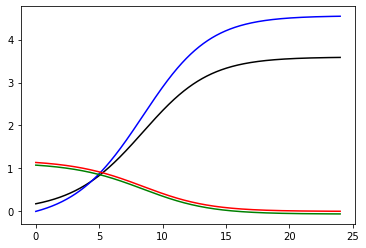

In [4]:
stream = bst.Stream('', units='kg/hr',H2O=10, Biomass=.05, Butyrate=1,CO2=0, Glycerol=1)

def kinetic_m(z, t):
    k=1.11
    qmax=2.8
    Ks1=1.88
    E=9.5

    X, C, B, G = z
    
    dPdt = X*qmax*k*(B/(B+E))
    dCdt =  dPdt*(1/0.75)
    dBdt = -dCdt/4
    dGdt = dBdt
    return (dPdt, dCdt, dBdt, dGdt)

def ODE(feed, tau):
    mass =feed.mass
    F_vol = feed.F_vol
    concentration_in = mass/F_vol
    X0, P0, S0, G0 = feed.get_concentration(('Biomass','CO2','Butyrate', 'Glycerol')) 
    # Integrate to get final concentration
    t = np.linspace(0, tau, 1000)
    C_t = odeint(kinetic_m, (X0, P0, S0, G0), t)
    # Cache data
    _P = C_t[:, 0]
    _C = C_t[:, 1]
    _B = C_t[:, 2]
    _G = C_t[:, 3]
    
    
    time = np.array(range(0,1))
    x = np.array(range(0,1))
    
    plt.plot(t, _P, color = 'black')
    plt.plot(t, _C, color = 'blue')
    plt.plot(t, _B, color = 'red')
    plt.plot(t, _G, color = 'green')

        
ODE(stream, 24)
    
Glycerol.MW

In [5]:
#Build flowchart of refinery
bst.main_flowsheet.set_flowsheet('reactor_section')

#feeds reactor
z_mass_crude_glycerol = chemicals.kwarray(dict(Glycerol=0.8, H2O=0.14, Salt=0.06))
R1feedcg = bst.Stream('R1feedcg', units='kg/hr',flow = 1.37*z_mass_crude_glycerol)
z_mass_seawater = chemicals.kwarray(dict(H2O=1000/1035,Salt=35/1035))
R1feedsw = bst.Stream('R1feedsw', flow=40*z_mass_seawater, units='kg/hr', T=303)
#amount_salt_to_add = 100-(R1feedcg.get_concentration('Salt') + R1feedsw.get_concentration('Salt'))
R1feed = bst.Stream('R1feed', units='kg/hr', Ammonium_Sulfate=0.31, Salt=1.08, Biomass=0.001)

#feed O2 in excess for now; compressor cost built into reactor
R1feedO2 = bst.Stream('R1feedO2', O2=4.5*R1feedcg.get_flow('kmol/hr','Glycerol'),units='kmol/hr')

R1 = BiomassEnrichment('R1', ins=(R1feed,R1feedsw,R1feedcg,R1feedO2), outs=('R1vent','R2feedR1'), iskinetic=False)

R1.simulate()
R1.show()
#for reference the kg cells made
amount_cells_made = R1.outs[1].get_flow('kmol/hr', 'Biomass')*24*1*28.5 # kmol*time*v*molecular weight

#R1.efficiency
#R1.results()

BiomassEnrichment: R1
ins...
[0] R1feed
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Ammonium_Sulfate  0.00235
                    Salt              0.0185
                    Biomass           3.57e-05
[1] R1feedsw
    phase: 'l', T: 303 K, P: 101325 Pa
    flow (kmol/hr): Water  2.15
                    Salt   0.0231
[2] R1feedcg
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water     0.0106
                    Glycerol  0.0119
                    Salt      0.00141
[3] R1feedO2
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): O2  0.0536
outs...
[0] R1vent
    phase: 'g', T: 303.15 K, P: 101325 Pa
    flow (kmol/hr): Water  0.00193
                    CO2    0.0136
                    O2     0.0337
[1] R2feedR1
    phase: 'l', T: 302.85 K, P: 101325 Pa
    flow (kmol/hr): Water             2.18
                    Glycerol          0.00285
                    Ammonium_Sulfate  0.00017
                    Salt              0.043
           

In [6]:
__all__ = ('Photobioreactor',)
@cost('Reactor volume', 'Agitators', CE=521.9, cost=52500,
      S=3785, n=0.5, kW=22.371, BM=1.5)
@cost('Reactor volume', 'Reactors', CE=521.9, cost=844000,
      S=3785, n=0.5, BM=1.5)
@cost('Reactor duty', 'Heat exchangers', CE=522, cost=23900,
      S=5*20920000.0, n=0.7, BM=2.2) # Based on a similar heat exchanger
class Photobioreactor(Unit):
    line = 'PBR'
    _N_ins = 2
    _N_outs = 2
    _units = {'Reactor volume': 'm3',
              'Reactor duty': 'kJ/hr'}
    _N_heat_utilities = 1
    
    def __init__(self, ID='', ins=None, outs=(), thermo=None, *,
                tau=24, V=1, T=303.15, P=101325,
                 efficiency=0.45, iskinetic=False):
        Unit.__init__(self, ID, ins, outs, thermo)
        
        self.reaction = Reaction('Butyrate -> Propane + CO2', reactant='Butyrate',
                                 X=efficiency, correct_atomic_balance=False)
        self.T=T
        self.P=P
        self.V=V
        self.iskinetic = iskinetic
        self.tau=tau
    
    
    def _OD465_calculation_biomass(x):
        if x < 0.2:
            OD = 4.063*x
        elif x>= 1:
            OD = 0.3281*np.log(x)+1.968
        else:
            OD = 1.237*x**3 - 3.8942*x**2 + 4.5063*x + 0.1
        return OD
    
    def _E(self, x): #Beer_Lambert_Light_Intensity
        I0 = 435 #incident light intensity (W/m2)
        l = 50 #light_path_length (mm)
        Iav = 216 #umol photon/m2*s
        
 #       (Iav*l*x*np.log10(10))/I0 * e = 1 - 10**(-e*x*l) 
        
  #      return e
        #need to solve for K

    
    @property
    def visualize_cell_growth(self):
        t = np.array(range(0,1))
        x = np.array(range(0,1))
        plt.plot(t, x, self._X, color = 'black', label='Propane')
        plt.plot(t, x, self._P, color = 'red', label='CO2')
        plt.plot(t, x, self._B, color = 'skyblue', label='Butyrate')
        plt.plot(t, x, self._G, color = 'orange', label='Glycerol')
        
    def _propane_reaction(self, feed, tau):
        mass = feed.mass
        F_vol = feed.F_vol
        concentration_in = mass/F_vol
        X0, P0, S0, G0 = feed.get_concentration(('Biomass','Propane','Butyrate', 'Glycerol'))
        t = np.linspace(0, tau, 1000)
        C_t = odeint(self.kinetic_model, (X0, P0, S0, G0), t)
        # Cache data
        self._X = C_t[:, 0]
        self._P = C_t[:, 1]
        self._B = B = C_t[:, 2]
        self._G = C_t[:, 3]
        # Calculate efficiency
        Sf = B[-1]
        Sf = Sf if Sf > 0 else 0
        eff = (S0 - Sf)/S0 
        return eff
        
    @staticmethod
    def kinetic_model(z, t):
        k=1.11
        qmax=2.8
        Ks1=1.88
        E=9.5

        X, C, B, G = z
    
        dPdt = X*qmax*k*(B/(B+E))
        dCdt =  dPdt*(1/0.75)
        dBdt = -dCdt/4
        dGdt = dBdt
        return (dPdt, dCdt, dBdt, dGdt)    
    
    @property
    def efficiency(self):
        return self.reaction.X
    @efficiency.setter
    def efficiency(self, efficiency):
        self.reaction.X = efficiency
        
    def _run(self):
        #make output a vent of gas and liquid stream
        vent, effluent = self.outs
        vent.phase = 'g'
        vent.T = effluent.T = self.T
        vent.P = effluent.P = self.P
        #mix in case 2 streams, and if kinetic selected use kinetic function
        effluent.mix_from(self.ins)
        effluent_mol = effluent.mol
        effluent_mass = effluent.mass
        if self.iskinetic:
            efficiency = self._propane_reaction(effluent, self.tau)
            self.reaction.X = efficiency
        self.reaction(effluent_mol) #reaction
        vent.receive_vent(effluent)

        
        
        
        #in design of reactor and cost
        Design = self.design_results
        duty = self.Hnet
        Design['Reactor duty'] = abs(duty)
        Design['Reactor volume'] = self.V
        self.heat_utilities[0](duty, self.T)

Photobioreactor: R2
ins...
[0] R2feedAD
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water     1.71
                    Butyrate  0.00723
[1] R2feedR1  from  BiomassEnrichment-R1
    phase: 'l', T: 302.85 K, P: 101325 Pa
    flow (kmol/hr): Water             2.18
                    Glycerol          0.00285
                    Ammonium_Sulfate  0.00017
                    Salt              0.043
                    Biomass           0.0136
outs...
[0] R2vent
    phase: 'g', T: 303.15 K, P: 101325 Pa
    flow (kmol/hr): Water    0.000302
                    CO2      0.00366
                    Propane  0.00366
[1] R2solids
    phase: 'l', T: 299.15 K, P: 101325 Pa
    flow (kmol/hr): Water             3.9
                    Butyrate          0.00357
                    Glycerol          0.00285
                    Ammonium_Sulfate  0.00017
                    Salt              0.043
                    Biomass           0.0136


/Users/hellpark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: undocked inlet stream R2feedR1 from unit R2; R2feedR1 is now docked at R2
  after removing the cwd from sys.path.


TypeError: 'NoneType' object is not callable

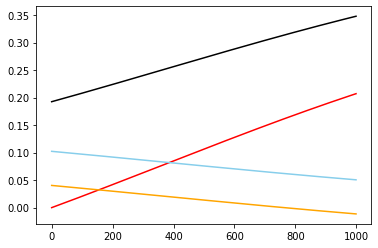

In [857]:
R2feedAD = bst.Stream('R2feedAD', Butyrate=0.63,Water=0.63/20*980, units='kg/hr')


R2 = Photobioreactor('R2',ins=(R2feedAD,R1.outs[1]),outs=('R2vent','R2solids'), iskinetic=True)

R1.simulate()
R2.simulate()
R2.show()
R2.efficiency
#R1.results()
R2.visualize_cell_growth()

In [770]:
R2feedAD = bst.Stream('R2feedAD', Butyrate=0.63,Water=0.63/20*980, units='kg/hr')


R2 = Photobioreactor('R2',ins=(R2feedAD,R1.outs[1]),outs=('R2vent','R2solids'))

R1.simulate()
R2.simulate()
R2.show()
#R1.efficiency
#R1.results()














#Resource recovery of Ectoine (use piracene here, assume 0.15g/gDCM)
bst.main_flowsheet.set_flowsheet('recovery_section')

made_ectoine = bst.Stream('made_ectoine',units='kg/hr',T=R2.outs[1].T)
made_ectoine.imass['Piracetam'] = R2.outs[1].imass['Butyrate'] * 0.15
made_ectoine.mix_from([made_ectoine,R2.outs[1]])

# Centrifuge and put through a filter (here its Rotary vacuum-drum filter) 
Centrifuge_1 = units.SolidsCentrifuge('Centrifuge_1', ins=(made_ectoine), outs=('culture_broth', 'cells'),
                            split=(.98, 0.98, 0.98, 0.98, 0.96, 0.01),
                            order=('Glycerol', 'Butyrate', 'Ammonium_Sulfate', 'Salt', 'Water', 'Biomass'),
                            solids=('Biomass',))
Microfilter_1 = units.RVF('Microfilter_1', ins=(Centrifuge_1.outs[1]), outs=('culture_broth2', 'cells2'),
                          moisture_content=0.60,
                             split=dict(Glycerol=0.6,
                                        Butyrate=0.6,
                                        Ammonium_Sulfate=0.6,
                                        Salt=0.6,
                                        Biomass=.002))
Centrifuge_1.simulate()
Microfilter_1.simulate()

#bacterial milking w/ addition of water, osmotic shock releases ectoine from biomass
milking_water = bst.Stream('milking_water', units='kmol/hr')
milking_water.imass['Water'] = Microfilter_1.outs[1].imass['Biomass']*10000
Milk_Tank_1 = units.MixTank('Milk_Tank_1', ins=([milking_water,Microfilter_1.outs[1]]), tau=0.10)
Milk_Tank_1.simulate()
#separate ectoine in water fraction from biomass in centrifuge
Centrifuge_2 = units.SolidsCentrifuge('Centrifuge_2', ins=(Milk_Tank_1.outs), outs=('ectoine_water', 'cells'),
                            split=(.98, 0.8, 0.98, 0.98, 0.96, 0.96,0.001),
                            order=('Water','Piracetam','Glycerol', 'Butyrate', 'Ammonium_Sulfate', 'Salt', 'Biomass'),
                            solids=('Biomass',))
Centrifuge_2.simulate()

#chromatography and crystallisation (not shown)
#heat to evaporate water
Heater_1 = units.HXutility('Heater_1', ins=(Centrifuge_2.outs[0]),T=350.15)
Split1 = units.Splitter('Split1', ins=(Heater_1.outs), outs=('Ectoine', 'WasteWater'), 
                        split={'Water': 0.01,'Piracetam': 0.98})
Heater_1.simulate()
Split1.simulate()
Split1.show()
Ectoine_purity = Split1.outs[0].get_flow('kg/hr', 'Piracetam')/Split1.outs[0].get_total_flow('kg/hr')



Photobioreactor: R2
ins...
[0] R2feedAD
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water     1.71
                    Butyrate  0.00723
[1] R2feedR1  from  BiomassEnrichment-R1
    phase: 'l', T: 302.85 K, P: 101325 Pa
    flow (kmol/hr): Water             2.18
                    Glycerol          0.00285
                    Ammonium_Sulfate  0.00226
                    Salt              0.043
                    Biomass           0.0146
outs...
[0] R2vent
    phase: 'g', T: 303.15 K, P: 101325 Pa
    flow (kmol/hr): Water    0.000268
                    CO2      0.00325
                    Propane  0.00325
[1] R2solids
    phase: 'l', T: 299.15 K, P: 101325 Pa
    flow (kmol/hr): Water             3.9
                    Butyrate          0.00398
                    Glycerol          0.00285
                    Ammonium_Sulfate  0.00226
                    Salt              0.043
                    Biomass           0.0146
Splitter: Split1
ins...
[0] s78  from  HX

/Users/hellpark/.local/lib/python3.7/site-packages/biosteam/units/_solids_centrifuge.py:71: DesignWarning: <SolidsCentrifuge: Centrifuge_1> Solids loading (1.606e-05 ton/hr) is out of bounds (minimum 2 ton/hr).
  lb_warning(self, 'Solids loading', ts, 'ton/hr', lb)
/Users/hellpark/.local/lib/python3.7/site-packages/biosteam/units/_solids_centrifuge.py:71: DesignWarning: <SolidsCentrifuge: Centrifuge_2> Solids loading (1.587e-05 ton/hr) is out of bounds (minimum 2 ton/hr).
  lb_warning(self, 'Solids loading', ts, 'ton/hr', lb)


In [496]:
Butyrate.MW
Split1.outs[0].get_flow('kg/hr', 'Piracetam')




87.09718

In [495]:
Glycerol, Butyrate, Ammonium_Sulfate, Salt, Water, Biomass



92.09382

In [494]:
Ammonium_Sulfate.MW



58.442769

In [493]:
Salt.MW



58.442769

In [428]:
R1.simulate()
R1.show()
R1.efficiency
R1.results()

BiomassEnrichment: R1
ins...
[0] R1feed
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Ammonium_Sulfate  0.00235
                    Salt              0.0698
                    Biomass           0.001
[1] R1feedsw
    phase: 'l', T: 303 K, P: 101325 Pa
    flow (kmol/hr): Water  2.13
                    Salt   2.31
[2] R1feedcg
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water     0.0106
                    Glycerol  0.0119
                    Salt      0.00141
[3] R1feedO2
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): O2  0.0536
outs...
[0] R1vent
    phase: 'g', T: 303.15 K, P: 101325 Pa
    flow (kmol/hr): Water  0.00073
                    CO2    0.000443
                    O2     0.0529
[1] R2feedR1
    phase: 'l', T: 302.87 K, P: 101325 Pa
    flow (kmol/hr): Water             2.15
                    Glycerol          0.0116
                    Ammonium_Sulfate  0.00235
                    Salt              2.39
                

Biomass Enrichment                     Units       R1
Power               Rate                  kW  0.00591
                    Cost              USD/hr 9.46e-05
Chilled water       Duty               kJ/hr     -191
                    Flow             kmol/hr    0.142
                    Cost              USD/hr 0.000954
Design              Reactor duty       kJ/hr      191
                    Reactor volume        m3        1
Purchase cost       Heat exchangers      USD     2.65
                    Reactors             USD 1.59e+04
                    Agitators            USD      986
Total purchase cost                      USD 1.68e+04
Utility cost                          USD/hr  0.00105